# Libraries & Helpers

In [41]:
# Libraries
import pandas as pd
import numpy as np
import gspread
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir("..")  
from src import config
from src import help_functions as hf

# Configs
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

# Data

In [42]:
# Import and quick check Training data 
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
training_data, _ = hf.import_google_sheet(googleDrive_client=googleDrive_client, filename=config.DRIVE_TP_LOG_FILENAMES[0], sheet_index=0)

# "Clean" data
for col in training_data.columns:
    try:
        training_data[col] = training_data[col].apply(hf.safe_convert_to_numeric)
    except ValueError:
        pass 

# Date & Datetime
training_data["Date"] = pd.to_datetime(training_data[["Year", "Month", "Day"]]).dt.date
training_data["Datetime"] = pd.to_datetime(training_data[["Year", "Month", "Day"]])
training_data = training_data.sort_values(by="Date").reset_index(drop=True)

# About
print("Training data about:")
print("-----------------------------------------------------")
print("Todays date: {}".format(datetime.datetime.today().date()))
print("Date range: {} to {}".format(training_data["Date"].min(), training_data["Date"].max()))
print("Duplicated rows = {}".format(training_data[training_data.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=training_data["Date"].min(), end=training_data["Date"].max()).date if d not in training_data["Date"].values]))

print("\nDifferent activities and their counts:")
print("-------------------------------------")
activities_count_time = (
    training_data
    .groupby("Activity type")[["Duration [h]"]]
    .agg(
        count=("Duration [h]", "count"),
        total_duration=("Duration [h]", "sum")
        )
    .reset_index()
    .sort_values(by="total_duration", ascending=False)
    )

for _, row in activities_count_time.iterrows():
    print("{} ~> {:.2f} hours ({} act.)".format(row["Activity type"], row["total_duration"], row["count"]))

Training data about:
-----------------------------------------------------
Todays date: 2025-09-03
Date range: 2024-09-13 to 2025-09-02
Duplicated rows = 0
Missing dates = []

Different activities and their counts:
-------------------------------------
Trail Running ~> 289.82 hours (155 act.)
Running ~> 79.24 hours (77 act.)
Road Biking ~> 78.77 hours (32 act.)
Indoor Biking ~> 71.04 hours (51 act.)
Mountain Biking ~> 16.99 hours (9 act.)
Hiking ~> 15.35 hours (6 act.)
Road biking ~> 3.74 hours (2 act.)
Indoor Cycling ~> 1.50 hours (1 act.)
Lap Swimming ~> 0.21 hours (1 act.)


In [43]:
# Import and quick check Daily data
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
daily_data, _ = hf.import_google_sheet(googleDrive_client=googleDrive_client, filename=config.DRIVE_TP_LOG_FILENAMES[1], sheet_index=0)

# "Clean" data
for col in daily_data.columns:
    try:
        daily_data[col] = daily_data[col].apply(hf.safe_convert_to_numeric)
    except ValueError:
        pass 

# Date & Datetime
daily_data["Date"] = pd.to_datetime(daily_data[["Year", "Month", "Day"]]).dt.date
daily_data["Datetime"] = pd.to_datetime(daily_data[["Year", "Month", "Day"]])
daily_data = daily_data.sort_values(by="Date").reset_index(drop=True)

# About
print("Daily data about:")
print("-----------------------------------------------------")
print("Todays date: {}".format(datetime.datetime.today().date()))
print("Date range: {} to {}".format(daily_data["Date"].min(), daily_data["Date"].max()))
print("Duplicated rows = {}".format(daily_data[daily_data.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=daily_data["Date"].min(), end=daily_data["Date"].max()).date if d not in daily_data["Date"].values]))

Daily data about:
-----------------------------------------------------
Todays date: 2025-09-03
Date range: 2024-04-15 to 2025-09-02
Duplicated rows = 0
Missing dates = []


# Goals

We have two goals:

1. **Recent Adjusted Relative Training Load (ARTL)**

Define a simple metric that shows where we are with our current training compared to what we've been doing in the recent past. The purpose is to see if we should reduce out trainings load — so that we don't overreach or risk injury, or increase increase it to match what what our body has been adapted to in recent past. Or just simple define where in the training cycle we are if we take larger picture into account. *How are we positined relative to recent training load overall?*

2. **Recent Load Relative Percentile (RLRP)**

Quantify how hard today's training was compared to what we are used to. In other words, show where this session fall within the distribution of our recent sessions — is it an average day, a light day, or a clear spike? This also helps guide tomorrow’s (or few next days) training choice, since we know whether today was relatively light, normal, or heavy.

Dataset:

- All activities, regardless if it was real training or not (including hiking, swimming, easy cycling etc.).
- Lets assume we only have one "real" workout per day and take total (sum) daily training load (one sample is one day). 

Let $TL_i$ be the training load of the day i.

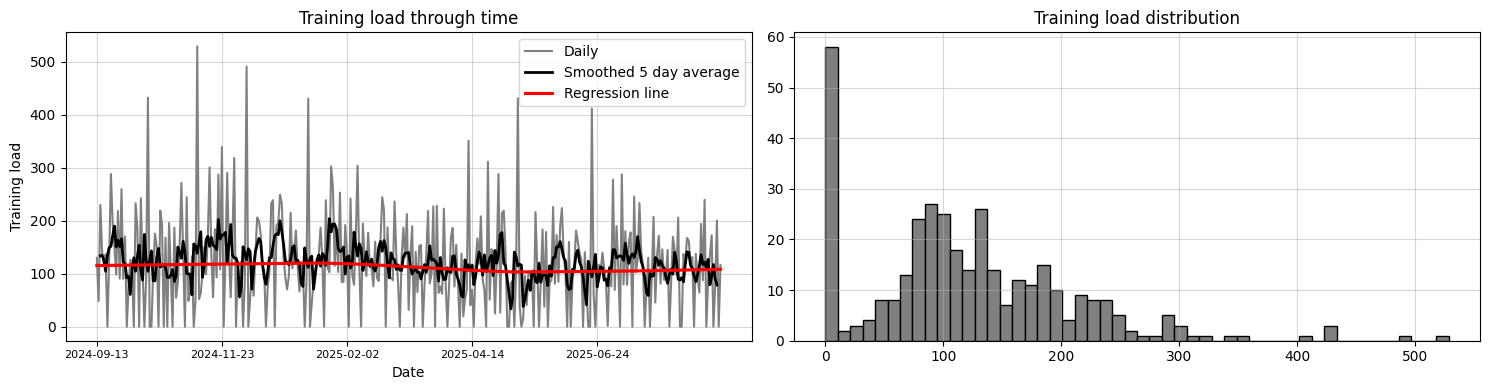

    Datetime  Training load                     Description
0 2025-04-12          350.6        Race Zalec Trail Running
1 2025-06-21          411.3       Race Tolmin Trail Running
2 2025-01-11          430.0      Race Nazarje Trail Running
3 2025-05-10          430.8       Race Idrija Trail Running
4 2024-10-12          431.9        Race Zalec Trail Running
5 2024-12-07          490.3      Race Velenje Trail Running
6 2024-11-09          528.6  Race Nova Gorica Trail Running


In [44]:
# Data:

rtl_data = (
    training_data
    .groupby("Datetime")
    .agg({
        "Training load": "sum",
        "Distance [km]": "sum",
        "Duration [h]": "sum",
        "Activity type": lambda x: " | ".join(map(str, x)),  
        "Description": lambda x: " | ".join(x)  
    })
    .reset_index()
    .assign(**{"Date index": lambda x: np.arange(x.shape[0])[::-1] + 1})
    # [["Date", "Training load"]]
)

# Exploratory data analysis - EDA
fig, ax = plt.subplots(1,2,figsize=(15, 4))
indices = np.arange(rtl_data.shape[0])

# Training load trough time
ax[0].set_title("Training load through time")
ax[0].plot(indices, rtl_data["Training load"], color="grey", label="Daily")
ax[0].plot(indices, rtl_data["Training load"].rolling(window=5, center=True).mean(), color="black", label="Smoothed 5 day average", linewidth=2)
sns.regplot(x=indices, y=rtl_data["Training load"], scatter=False, lowess=True, color="red", label="Regression line", ax=ax[0])
ax[0].legend()

ax[0].set_xticks(indices[::max(1, len(indices)//5)])  
ax[0].set_xticklabels(rtl_data["Datetime"].dt.strftime("%Y-%m-%d")[::max(1, len(indices)//5)], fontsize=8, rotation=0)
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Training load")

# Training load distribution
ax[1].set_title("Training load distribution")
ax[1].hist(rtl_data["Training load"], bins=50, color="grey", edgecolor="black")

for i in [0,1]:
    ax[i].grid(alpha=.5)
        
plt.tight_layout()
plt.show()

print(
    rtl_data
    .sort_values("Training load")
    [["Datetime", "Training load", "Description"]]
    .tail(7)
    .reset_index(drop=True)
)



# History-Aware Stratified Relative Training Load (HASRTL)
---
---

### Idea

When training for endurance sports, our bodies adapt over time, and whether a workout is "hard" or "easy" on the body, depends on what we’ve been doing recently and historically. To capture this, we want a **history-aware measure of current relative load**, which compares recent training to what the body has been successfully adapted to over a longer period.

We can think of this in two complementary components:

- Baseline (long term) adaptation - Load your body has been (succesfully) adapted to over a longer period, disregarding recent acute load.
    - Denoted as $TL_{\text{baseline},t}$.
    - Computed over a long baseline window of $N$ days, excluding last $n$ days: $\mathcal{L}_t=\{TL_{t-(n+j)}\mid j=1,\dots, N\}$ 
    - To give more importance to recent training within the baseline period, we assign weights decreasing with days: $w_j = \lambda^{j-1}, \quad 0 < \lambda <= 1, \quad j = 1, ..., N$, where more recent baseline days contribute more to defining the baseline load.

- Recent training pattern - Load our body is being exposed to in the recent window - reflects acute training load.
    - Denotes $TL_{\text{recent},t}$.
    - Computed over a recent window of $n$ days: $\mathcal{R}_t=\{TL_{t-j}\mid j=1,\dots,n\}$.
    - This can also be weighted to emphasize the most recent sessions: $v_j = \lambda^{j-1}, \quad 0 < \lambda <= 1, \quad j = 1, ..., n$

We define the parameters as:
- Baseline window: N = 90 days
- Recent window: n = 14 days
- Weight base $\lambda$ = $(0.5)^\frac{1}{31} = 0.978$, so weight halves approximately every 31 days.

Additionaly: Because we aim to capture relative load patterns rather than total accumulated load, we normalize the weights so that they sum to 1. This ensures that the weighted, for example averages, for baseline and recent windows are directly comparable: 

- $\overline{w}_j = \frac{w_j}{\sum_{k=1}^{N}w_k} \quad j = 1, ..., N$
- $\overline{v}_j = \frac{v_j}{\sum_{k=1}^{v}w_k} \quad j = 1, ..., v$

In [75]:
# Define parameters
baseline_window = 90
recent_window = 14
lambda_base = 0.978

In [104]:
# Define weights once for all
baseline_window_days = range(1, baseline_window+1)
baseline_window_weights = np.array([lambda_base ** (j-1) for j in baseline_window_days])
baseline_window_normalized_weights = baseline_window_weights / sum(baseline_window_weights)

recent_window_days = range(1, recent_window+1)
recent_window_weights = np.array([lambda_base ** (j-1) for j in recent_window_days])
recent_window_normalized_weights = recent_window_weights / sum(recent_window_weights)

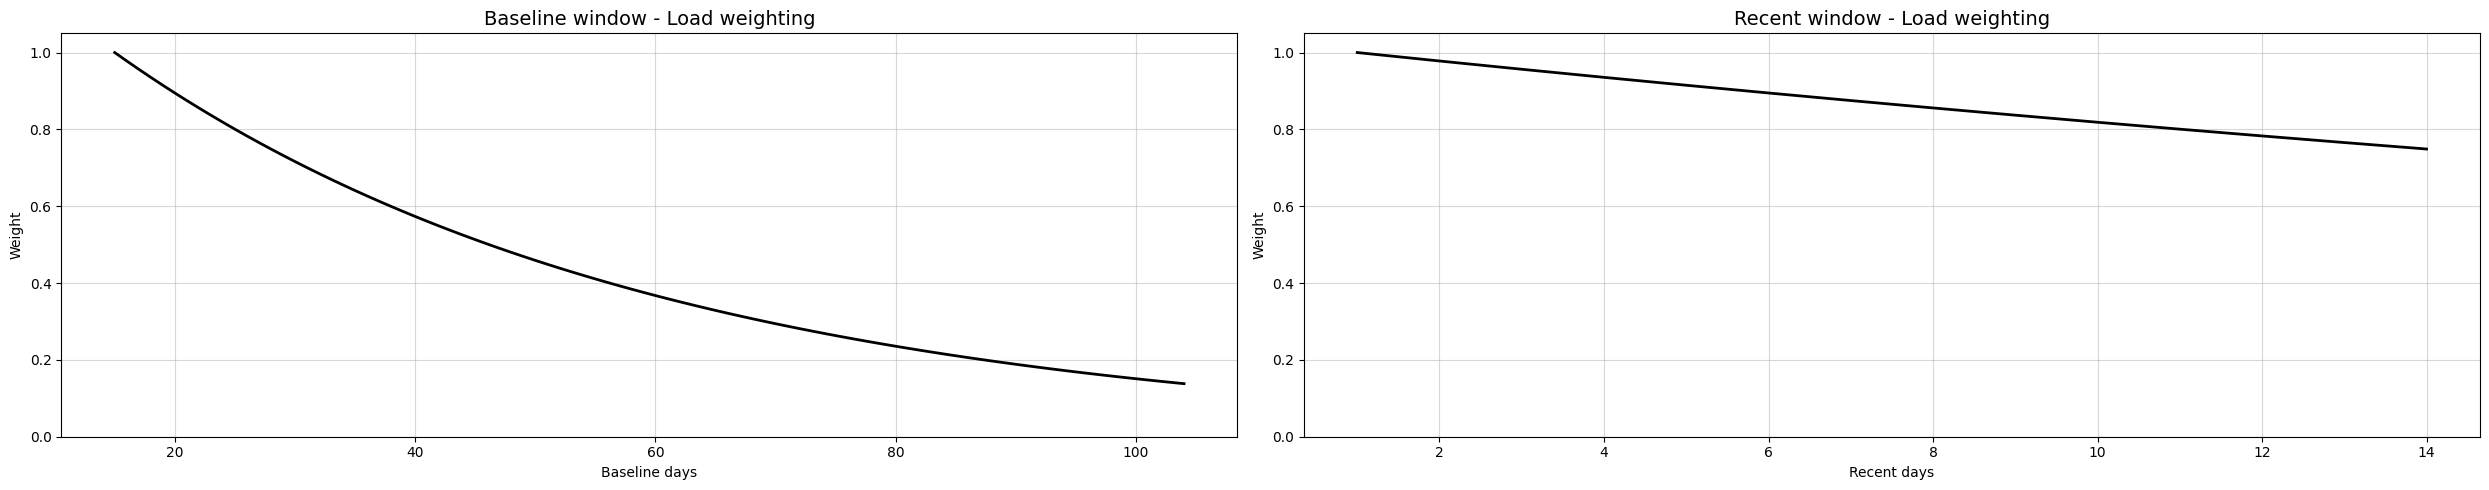

In [105]:
# How do we weight the days?

fig, ax = plt.subplots(1,2, figsize=(25,5))

ax[0].set_title("Baseline window - Load weighting", fontsize=14)
baseline_window_days = range(1, 91)
baseline_window_weights = np.array([lambda_base ** (j-1) for j in baseline_window_days])
# baseline_window_normalized_weights = baseline_window_weights / sum(baseline_window_weights)
ax[0].plot(np.repeat(14, 90) + baseline_window_days, baseline_window_weights, color="black", linewidth=2)
ax[0].set_xlabel("Baseline days")


ax[1].set_title("Recent window - Load weighting", fontsize=14)
recent_window_days = range(1, 15)
recent_window_weights = np.array([lambda_base ** (j-1) for j in recent_window_days])
# recent_window_normalized_weights = recent_window_weights / sum(recent_window_weights)
ax[1].plot(recent_window_days, recent_window_weights, color="black", linewidth=2)
ax[1].set_xlabel("Recent days")

for i in [0,1]:
    ax[i].set_ylim(0,1.05)
    ax[i].set_ylabel("Weight")
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

### Percentile stratified metric

In endurance sports, training days (including races) can be grouped into a few main types:
- **Easy & medium long sessions** - used for recovery, aerobic base, and technique work. These make up roughly 70% of all sessions.
- **Hard sessions** - tempo, threshold, VO2max, or interval workouts. Typically around 20% of sessions.
- **Long days** - the occasional very long run, bike ride, or race that forms the extreme right tail of the distribution. About 10% of sessions.
- **Other** - longer bike days, longer hikes, multiple activities in one day etc.
- **Rest days** - no training at all.

In [46]:
# Define easy, hard and long days ~ cca (hard to trully distinct them)
rtl_data["easy_hard_long_description"] = pd.Series(dtype="object")

# Rest days
rest_mask = rtl_data["Description"] == "Rest"
rtl_data.loc[rest_mask, "easy_hard_long_description"] = "rest"

# Eays days (No special description, duration < 1.5h)
easy_mask = (
    (rtl_data["Duration [h]"] <= 2.0) &
    (rtl_data["Description"].str.contains("Running|Workout|Biking|Aerobni|Lahkoten|Hiking|Aktivacija ", case=False, na=False)) &
    ~(rtl_data["Description"].str.contains("Race", case=False, na=False)) & 
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[easy_mask, "easy_hard_long_description"] = "easy"

# Hard days (Special description, duration < 2h)
hard_mask = (
    (rtl_data["Duration [h]"] <= 2.0) &
    (rtl_data["Description"] .str.contains("INT|TT|PWH|LT|x")) &
    ~(rtl_data["Description"].str.contains("Running|Biking|Workout|Aerobni|Lahkoten|Hiking|Aktivacija ", case=False, na=False)) & 
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[hard_mask, "easy_hard_long_description"] = "hard"

# Long days (No special description, duration >= 2h)
long_mask = (
    (rtl_data["Duration [h]"] >= 2.0)  &
    (rtl_data["Description"].str.contains("Running|Dolgi|Tek|x", case=False, na=False)) & 
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[long_mask, "easy_hard_long_description"] = "long"

# Other (medium long days, other ...)
other_mask = (
    (rtl_data["easy_hard_long_description"].isnull())
)
rtl_data.loc[other_mask, "easy_hard_long_description"] = "other"

In [47]:
# About
print("Easy, hard, long days - description:")
print("-----------------------------------------------------")
for value in ["easy", "hard", "long", "other", "rest"]:
    data_tmp = rtl_data.query("easy_hard_long_description == @value")
    print("{} ~> {} ({}% | *{}%) ~> [mean = {}, SD = {}]".format(
        value, 
        data_tmp.shape[0],
        round(data_tmp.shape[0]/rtl_data.shape[0] * 100, 2),
        round(data_tmp.shape[0]/rtl_data.query("easy_hard_long_description != 'rest'").shape[0] * 100, 2),
        round(data_tmp["Training load"].mean(), 2),
        round(data_tmp["Training load"].std(), 2)
        ))
print("* ~> Without rest days included in proportions")

Easy, hard, long days - description:
-----------------------------------------------------
easy ~> 166 (46.76% | *54.43%) ~> [mean = 95.96, SD = 43.23]
hard ~> 51 (14.37% | *16.72%) ~> [mean = 189.76, SD = 56.21]
long ~> 66 (18.59% | *21.64%) ~> [mean = 217.22, SD = 96.78]
other ~> 22 (6.2% | *7.21%) ~> [mean = 133.35, SD = 69.5]
rest ~> 50 (14.08% | *16.39%) ~> [mean = 0.0, SD = 0.0]
* ~> Without rest days included in proportions


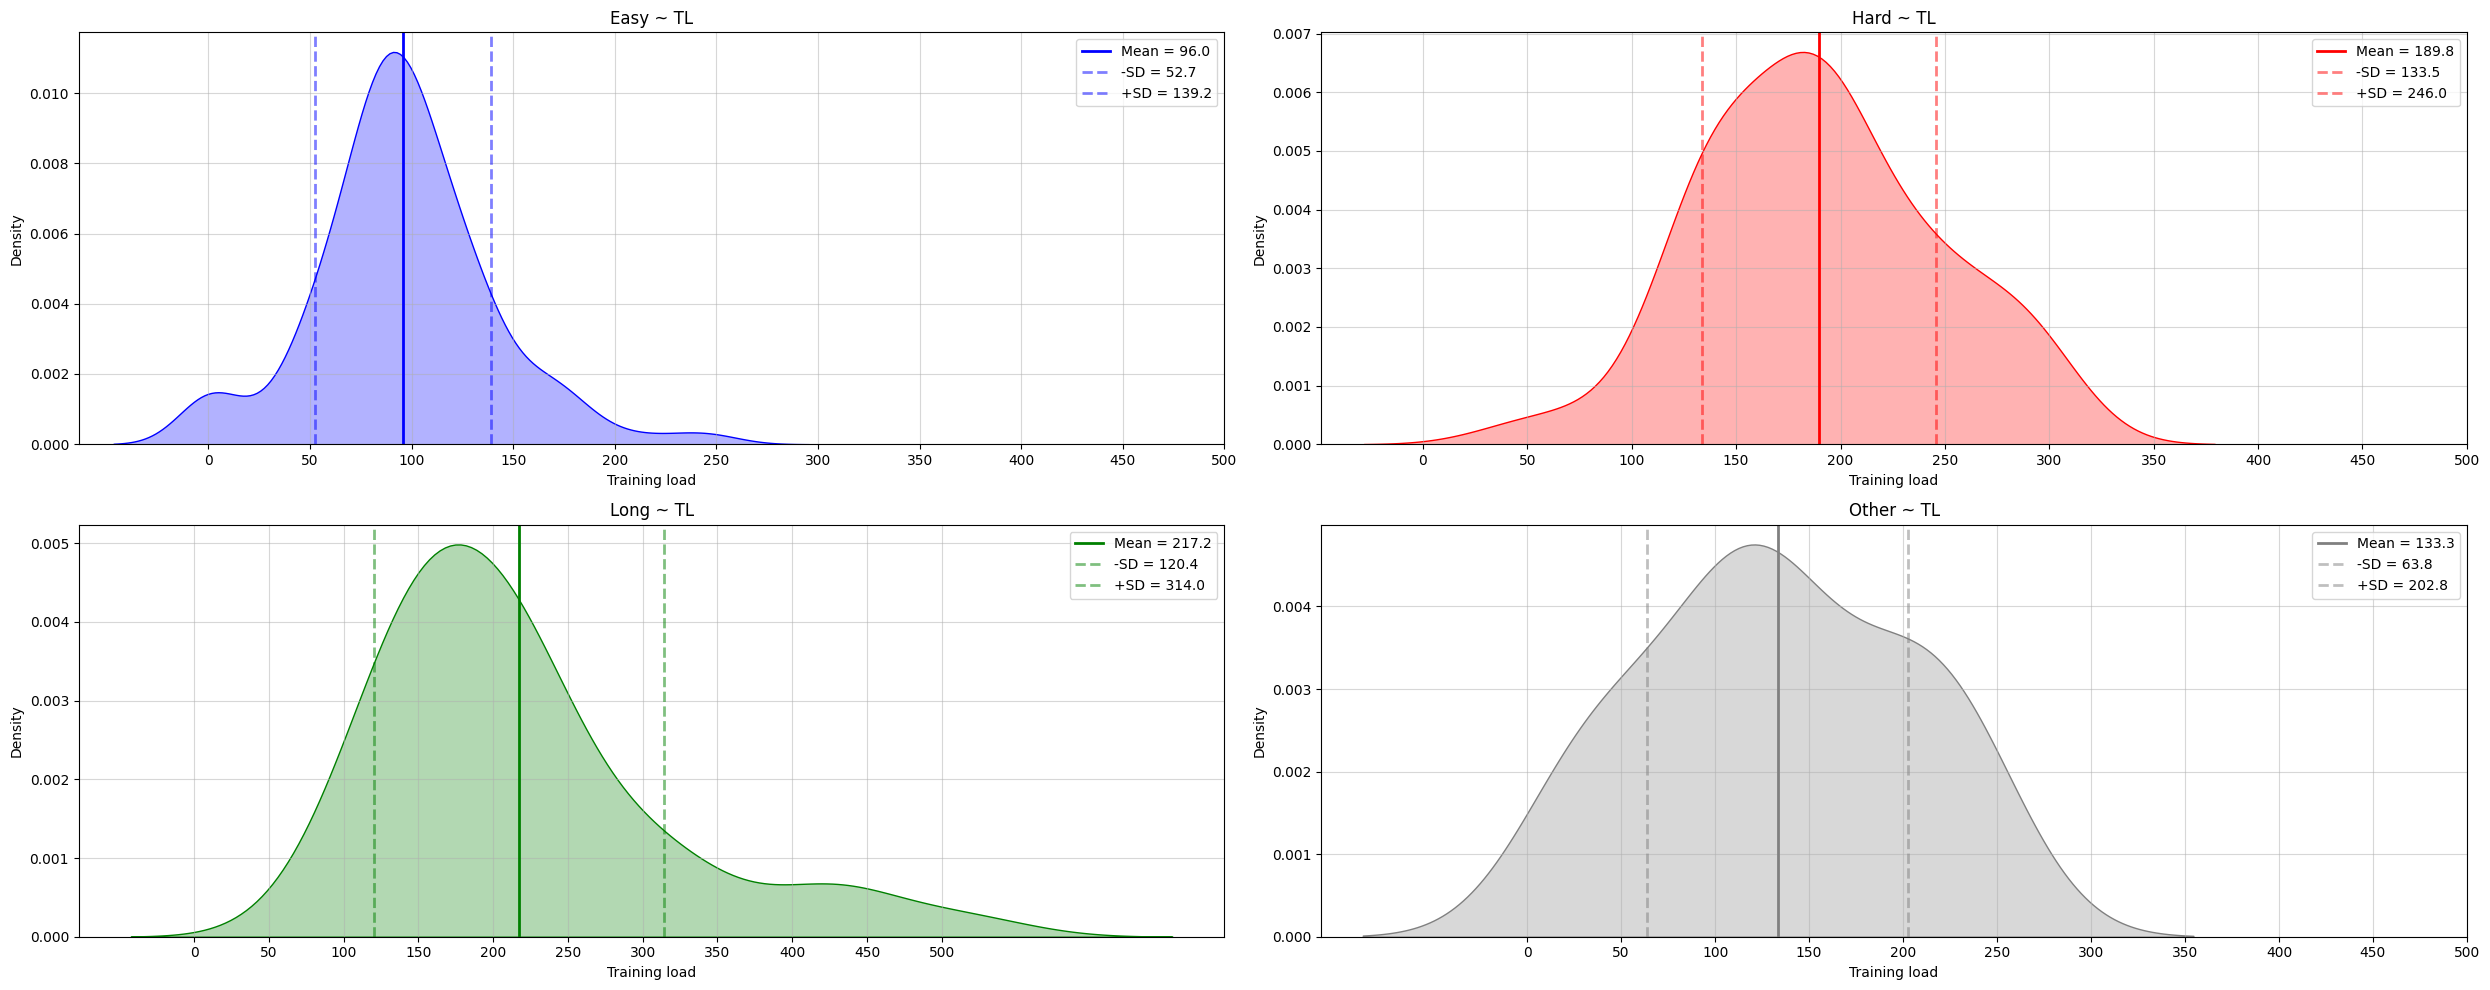

In [48]:
# Plot 1
fig, ax = plt.subplots(2,2,figsize=(25, 10))

colors = {"easy": "blue", "hard": "red", "long": "green", "other": "grey"}
categories = ["easy", "hard", "long", "other"]

ax[0,0].set_title("Easy ~ TL")
easy_tmp = rtl_data.query("easy_hard_long_description == 'easy'")["Training load"]
sns.kdeplot(easy_tmp, color="blue", fill=True, alpha=0.3, ax=ax[0,0])
ax[0,0].axvline(easy_tmp.mean(), color="blue", linestyle="-", linewidth=2, label=f"Mean = {easy_tmp.mean():.1f}")
ax[0,0].axvline(easy_tmp.mean() - easy_tmp.std(), color="blue", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {easy_tmp.mean() - easy_tmp.std():.1f}")
ax[0,0].axvline(easy_tmp.mean() + easy_tmp.std(), color="blue", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {easy_tmp.mean() + easy_tmp.std():.1f}")

ax[0,1].set_title("Hard ~ TL")
hard_tmp = rtl_data.query("easy_hard_long_description == 'hard'")["Training load"]
sns.kdeplot(hard_tmp, color="red", fill=True, alpha=0.3, ax=ax[0,1])
ax[0,1].axvline(hard_tmp.mean(), color="red", linestyle="-", linewidth=2, label=f"Mean = {hard_tmp.mean():.1f}")
ax[0,1].axvline(hard_tmp.mean() - hard_tmp.std(), color="red", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {hard_tmp.mean() - hard_tmp.std():.1f}")
ax[0,1].axvline(hard_tmp.mean() + hard_tmp.std(), color="red", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {hard_tmp.mean() + hard_tmp.std():.1f}")

ax[1,0].set_title("Long ~ TL")
long_tmp = rtl_data.query("easy_hard_long_description == 'long'")["Training load"]
sns.kdeplot(long_tmp, color="green", fill=True, alpha=0.3, ax=ax[1,0])
ax[1,0].axvline(long_tmp.mean(), color="green", linestyle="-", linewidth=2, label=f"Mean = {long_tmp.mean():.1f}")
ax[1,0].axvline(long_tmp.mean() - long_tmp.std(), color="green", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {long_tmp.mean() - long_tmp.std():.1f}")
ax[1,0].axvline(long_tmp.mean() + long_tmp.std(), color="green", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {long_tmp.mean() + long_tmp.std():.1f}")

ax[1,1].set_title("Other ~ TL")
other_tmp = rtl_data.query("easy_hard_long_description == 'other'")["Training load"]
sns.kdeplot(other_tmp, color="grey", fill=True, alpha=0.3, ax=ax[1,1])
ax[1,1].axvline(other_tmp.mean(), color="grey", linestyle="-", linewidth=2, label=f"Mean = {other_tmp.mean():.1f}")
ax[1,1].axvline(other_tmp.mean() - other_tmp.std(), color="grey", alpha=.5, linestyle="--", linewidth=2, label=f"-SD = {other_tmp.mean() - other_tmp.std():.1f}")
ax[1,1].axvline(other_tmp.mean() + other_tmp.std(), color="grey", alpha=.5, linestyle="--", linewidth=2, label=f"+SD = {other_tmp.mean() + other_tmp.std():.1f}")

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xticks(np.arange(0, rtl_data["Training load"].max()+1, step=50))
        ax[i,j].grid(alpha=.5)
        ax[i,j].legend()

plt.tight_layout()
plt.show()

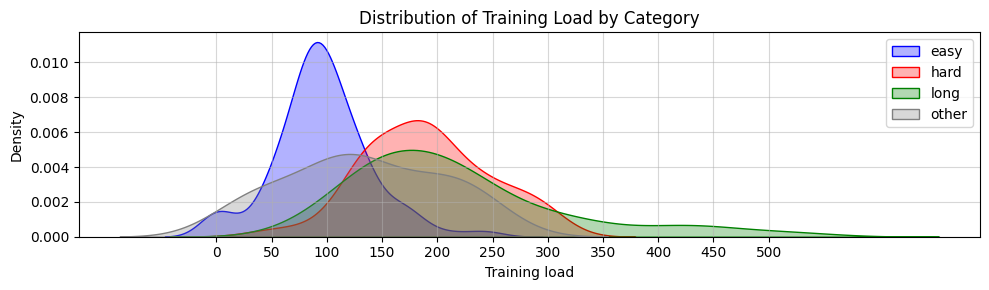

In [49]:
# Plot 2
fig, ax = plt.subplots(1,1, figsize=(10,3))

colors = {"easy": "blue", "hard": "red", "long": "green", "other": "grey"}
categories = ["easy", "hard", "long", "other"]

for cat in categories:
    tmp = rtl_data.query("easy_hard_long_description == @cat")["Training load"]
    color = colors[cat]
    sns.kdeplot(tmp, color=color, fill=True, alpha=0.3, ax=ax, label=cat)

ax.set_xticks(np.arange(0, rtl_data["Training load"].max()+1, step=50))

ax.set_xlabel("Training load")
ax.set_ylabel("Density")
ax.set_title("Distribution of Training Load by Category")
ax.legend()

plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

Now, to create a history-aware measure of current relative load, we have to take into account all of these three types of sessions, as they all contribute to our overall training load and adaptation, each in their own way. 
- Even though **easy and medium-long** sessions are individually low-stress, small increases in duration, intensity, or frequency can gradually accumulate, potentially pushing the body beyond its adapted baseline. They also form the foundation for recovery and adaptation from harder sessions, so they should not be too long, too intense, or too rare, ensuring that we can perform well in harder workouts.
- **Hard sessions** are important for performance improvement but carry higher risk of fatigue and overreaching. By tracking them separately, we can see if recent hard sessions exceed what the body is adapted to, indicating higher acute load. They should also make up a reasonable portion of total sessions to allow sufficient recovery.
- **Long days** are infrequent but highly taxing. Monitoring their frequency and intensity relative to baseline ensures they are not too frequent or extreme, reducing risk of excessive fatigue or injury.

We will divide all sessions into these three categories based on Training Load percentiles inside a rolling window (separately for baseline and recent windows). We use percentiles to classify sessions because this approach is individualized, automatic, and reproducible. Manually assigning sessions to categories would be impractical and inconsistent. 

- Let $\mathcal{Q}^w_p(\mathcal{L}_t)$ be weighted $p$-th quantile of $\mathcal{L}_t$ using weights $w_j$ and
- $\mathcal{Q}^w_p(\mathcal{R}_t)$ be weighted $p$-th quantile of $\mathcal{R}_t$ using weights $v_j$.

We will use the following cutpoints:
- **Easy sessions**: Training loads falling below the weighted 70th percentile of the window.
    - Baseline: $TL \leq q^w_{70,t}=Q^w_{0.70}(\mathcal{L}_t)$
    - Recent: $TL \leq r^w_{70,t}=Q^w_{0.70}(\mathcal{R}_t)$
- **Hard sessions**: Training loads between the weighted 70th and 90th percentiles.
    - Baseline: $q^w_{70,t} < $ TL $\leq q^w_{90,t}=Q^w_{0.90}(\mathcal{L}_t)$
    - Recent: $r^w_{70,t} < $ TL $\leq r^w_{90,t}=Q^w_{0.90}(\mathcal{R}_t)$
- **Long days**: Training loads above the weighted 90th percentile.
    - Baseline: $TL > q^w_{90,t}=Q^w_{0.90}(\mathcal{L}_t)$
    - Recent: $TL > r^w_{90,t}=Q^w_{0.90}(\mathcal{R}_t)$

**Note about weighted percentiles**: When we say weighted 70th percentile, we want a threshold in terms of the training load (TL) that accounts for the weights of the individual TL values. Basically we soprt TLs in ascending order and then compute the cumulative sum of weights along this in sorted TL list. The weighted 70th percentile is the TL where this cumulative sum reaches 70% of the total weight.

Having defined these buckets, we summarize each bucket by the weighted average training load within, where we allow more recent training days to contribute more to the bucket averages. With this, we make the metric sensitive to shifts in the typical intensity of each type of session within the bucket. 

Let $w_j$ be the weight of day $j$ in the baseline window $\mathcal{L}_t$ and $v_j$ be the weight of day $j$ in the recent window $\mathcal{R}_t$. We then define the weighted averages within each bucket as:

**Baseline bucket weighted averages:**
- Easy: $\mu^w_{1,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{L}_t,\; TL \le q^w_{70,t}\,]$
- Hard: $\mu^w_{2,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{L}_t,\; q^w_{70,t} < TL \le q^w_{90,t}\,]$
- Long: $\mu^w_{3,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{L}_t,\; TL > q^w_{90,t}\,]$

**Recent bucket weighted averages:**
- Easy: $\nu^w_{1,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{R}_t,\; TL \le r^w_{70,t}\,]$
- Hard: $\nu^w_{2,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{R}_t,\; r^w_{70,t} < TL \le r^w_{90,t}\,]$
- Long: $\nu^w_{3,t} = \mathbb{E}_w[\,TL \mid TL \in \mathcal{R}_t,\; TL > r^w_{90,t}\,]$

Where $\mathbb{E}[\cdot]$ denotes the empirical weighted mean over the subset of training load values falling into the specified bucket.

In [ ]:
# Calculate averages within each bucket for baseline rolling windows

# Helper ~ Compute weighted quantile
def weighted_quantile(values, weights, quantile):

    

# WORK ON THIS :)

rtl_data["baseline_b1_TL_mean"] = (
    rtl_data
    ["Training load"]
    .rolling(window=baseline_window, min_periods=baseline_window)
    .apply(lambda x: x[x <= x.quantile(0.7)].mean(), raw=False)
    .mask(lambda s: s.index >= s.index[-recent_window])
)

rtl_data["baseline_b2_TL_mean"] = (
    rtl_data
    ["Training load"]
    .rolling(window=baseline_window, min_periods=baseline_window)
    .apply(lambda x: x[(x > x.quantile(0.7)) & (x <= x.quantile(0.9))].mean(), raw=False)
    .mask(lambda s: s.index >= s.index[-recent_window])
)

rtl_data["baseline_b3_TL_mean"] = (
    rtl_data
    ["Training load"]
    .rolling(window=baseline_window, min_periods=baseline_window)
    .apply(lambda x: x[x > x.quantile(0.9)].mean(), raw=False)
    .mask(lambda s: s.index >= s.index[-recent_window])
)

In [51]:
# Calculate averages within each bucket for baseline rolling windows

rtl_data["recent_b1_TL_mean"] = (
    rtl_data
    ["Training load"]
    .iloc[baseline_window:] 
    .rolling(window=recent_window, min_periods=recent_window)
    .apply(lambda x: x[x <= x.quantile(0.7)].mean(), raw=False)
)

rtl_data["recent_b2_TL_mean"] = (
    rtl_data
    ["Training load"]
    .iloc[baseline_window:] 
    .rolling(window=recent_window, min_periods=recent_window)
    .apply(lambda x: x[(x > x.quantile(0.7)) & (x <= x.quantile(0.9))].mean(), raw=False)
)

rtl_data["recent_b3_TL_mean"] = (
    rtl_data
    ["Training load"]
    .iloc[baseline_window:] 
    .rolling(window=recent_window, min_periods=recent_window)
    .apply(lambda x: x[x > x.quantile(0.9)].mean(), raw=False)
)

In [ ]:
# Baseline buckets average & Recent buckets average ~ Incremental calculation ...

# Help function
def update_baseline_recent_buckets_averages(df, baseline_window, recent_window, agg_metric):

    # Fill missing metrics values row by row ~ Baseline 
    baseline_mask = df[["baseline_b1_TL_mean", "baseline_b2_TL_mean", "baseline_b3_TL_mean"]].isna().any(axis=1)
    for idx in df.index[baseline_mask]:

        first_baseline_row = idx - baseline_window + 1
        last_baseline_row = idx

        # Do we have enough history?
        if first_baseline_row >= 0:
            baseline_set = df.loc[first_baseline_row : last_baseline_row, agg_metric]

            # Compute values
            q70_baseline, q90_baseline = baseline_set.quantile([0.7, 0.9])
            df.at[idx, "baseline_b1_TL_mean"] = baseline_set[baseline_set <= q70_baseline].mean()
            df.at[idx, "baseline_b2_TL_mean"] = baseline_set[(baseline_set > q70_baseline) & (baseline_set <= q90_baseline)].mean()
            df.at[idx, "baseline_b3_TL_mean"] = baseline_set[baseline_set > q90_baseline].mean()

    # Fill missing metrics values row by row ~ Recent 
    recent_mask = df[["recent_b1_TL_mean", "recent_b2_TL_mean", "recent_b3_TL_mean"]].isna().any(axis=1)
    for idx in df.index[recent_mask]:

        first_recent_row = idx - recent_window + 1
        last_recent_row = idx

        # Do we have enough history?
        if first_recent_row >= 0:
            recent_set = df.loc[first_recent_row : last_recent_row, agg_metric]

            # Compute values
            q70_recent, q90_recent = recent_set.quantile([0.7, 0.9])
            df.at[idx, "recent_b1_TL_mean"] = recent_set[recent_set <= q70_recent].mean()
            df.at[idx, "recent_b2_TL_mean"] = recent_set[(recent_set > q70_recent) & (recent_set <= q90_recent)].mean()
            df.at[idx, "recent_b3_TL_mean"] = recent_set[recent_set > q90_recent].mean()

    # Return
    return df

# Gogo!
rtl_data[[
    "baseline_b1_TL_mean", "baseline_b2_TL_mean", "baseline_b3_TL_mean",
    "recent_b1_TL_mean", "recent_b2_TL_mean", "recent_b3_TL_mean",
    ]] = np.nan

rtl_data = update_baseline_recent_buckets_averages(df = rtl_data, baseline_window = baseline_window, recent_window = recent_window, agg_metric = "Training load")

Once we have defined baseline and recent Stratified Load Averages (SLA) $\mu_{k,t}$ and $\nu_{k,t}$, we can perform a series of **bucket level diagnostics** before constructing the final metric, the History-Aware Stratified Relative Training Load (HASRTL).

1. **Within-window SLA comparisons** 
By comparing SLAs within the same window (baseline and recent), we gain insight into the structure and balance of the training program. This allows us to evaluate whether the training is appropriately stratified across session types for best adaptation - Are the easy, hard, and long sessions clearly distinct, or do the load differences shrink, reducing meaningful variation for optimal adaptation? In practice, we compare SLAs pairwise:

$$\zeta_{\mu_i, \mu_j} = \frac{\mu_{i,t}}{\mu_{j,t}} \quad \text{and} \quad \zeta_{\nu_i, \nu_j} = \frac{\nu_{i,t}}{\nu_{j,t}}, \quad i,j = 1,2,3, i \neq j$$

2. **Baseline vs. recent SLA comparisons**

Next, we can compare recent SLAs to baseline SLAs for each bucket. This reveals how training is evolving over time and identifies which types of sessions are driving changes in overall load.
For example, a rise in $\delta_{1,t}$ might indicate that easy sessions are gradually becoming more demanding, whereas an increase in $\delta_{3,t}$ would point to unusually hard long sessions.

$$\delta_{k,t} = \frac{\nu_{k,t}}{\mu_{k,t}}, \quad k = 1,2,3$$

Together, these diagnostics provide both a detailed picture of training composition and evolution and the foundation for interpreting the aggregated HASRTL metric.

In [71]:
# GOGO

**Defining the History-Aware Stratified Relative Training Load (HASRTL)**

Once training sessions are divided into the three percentile-based buckets, we can combine them into a single, interpretable metric that reflects how recent training compares to the athlete’s long-term adaptation. The central idea is weighted aggregation, where each bucket contributes differently to the overall metric:

- **Easy sessions**: Frequent but low-stress. Weight reflects their cumulative impact on overall load.
- **Hard sessions**: Less frequent but higher intensity. Weight reflects their contribution to acute stress.
- **Long days**: Rare but highly taxing. Weight reflects their peak stress contribution.

By aggregating the per-bucket loads with appropriate weights, HASRTL produces a single number that reflects how the overall recent training load compares to the baseline adaptation. Also, because the metric is built from the individual buckets, as we have seen above, we can inspect each session type separately to see which types of workouts are driving increases or spikes.

**Weighted aggregation**

Let $w_1, w_2, w_3$ denote weights for easy, hard, and long sessions, respectively, with $$w_1+w_2+w_3=1,\quad w_k\ge 0$$
The baseline aggregate load is then: $$ TL_{\text{baseline},t} = w_1 \mu_{1,t} + w_2 \mu_{2,t} + w_3 \mu_{3,t} $$
Similarly, the recent aggregate load is: $$ TL_{\text{recent},t} = w_1 \nu_{1,t} + w_2 \nu_{2,t} + w_3 \nu_{3,t} $$

The overal relative load, or the **History-Aware Stratified Relative Training Load (HASRTL)** is defined as:

$$\Delta_t = \frac{TL_{\text{recent}}}{TL_{\text{baseline}}}$$

- $\Delta_t > 1$ indicates that recent training exceeds the baseline adaptation.
- $\Delta_t < 1$ indicates that recent training is below the baseline.

In [72]:
# GOGO! 
# DEFINE WEIGHTS - ANALYSIS